# This notebook illustrates Fourier analysis of nonrandom point sources
## Specifically thinking of d/dt[KE] = [bw] spikes in convective clouds
### Work in a pylab session: clean, basic tools

In [1]:
# This magic line loads numpy, scipy, matplotlib. 
# add the word inline to put figures inline
%pylab inline

plt.xkcd() # whiteboard style to plots

Populating the interactive namespace from numpy and matplotlib


## Experiment with specifying y(x)...

In [2]:
# 32 values for clarity of plot discreteness 
x = arange(128)/128. *2*pi

# wavenumbers 3-7, with amplitude 2 in #3-sine components, and a mean 
compose='y = 2*sin(3*x) - cos(4*x) + sin(5*x) - sin(6*x) + sin(7*x) + 1'
exec(compose)

# A square wave
#y = sin(5*x) > 0

# A sawooth wave
#x = arange(64)
#y = x % 60

# An isolated boxcar
compose='spikes, not quite random'
y = abs((x-1)%1) <0.03

y = detrend(y) # this subtracts the mean

## Plot the series, two copies for clarity 

Text(0.5, 1.0, 'spikes, not quite random')

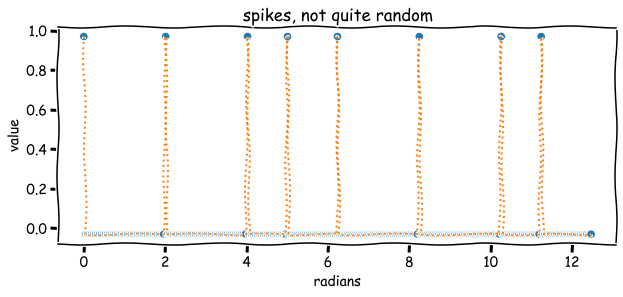

In [3]:
# Plot it, repeated since Fourier analysis assumes periodicity 
xx = concatenate((x, x+max(x)))
yy = concatenate((y, y       ))

# Plot the discrete values as dots '.', 
# connected by a dotted line ':'
figsize(10,4)

plot(xx,yy,'o', label='raw'); xlabel('radians'); ylabel('value')
plot(xx,yy,':', label='raw')
title(compose) #+', repeated');

## SFT = Slow Fourier Transform (illustration)

Text(0.5, 0, 'radians')

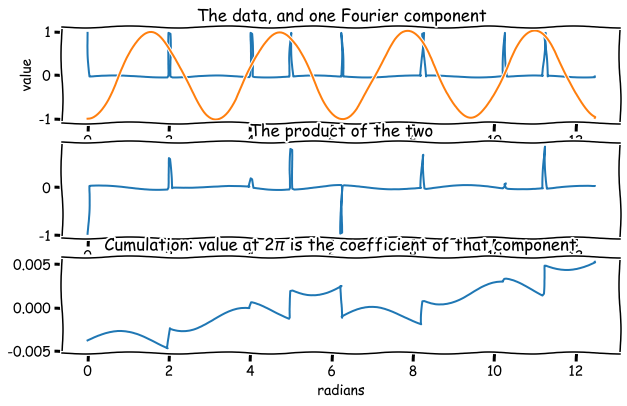

In [4]:
# Slow Fourier transform: mean of product of sin() and data
figsize(10,6)

subplot(311)
plot(xx,yy)
title('The data, and one Fourier component')
plot(xx, -cos(2*xx)); ylabel('value')

subplot(312)
product = yy * -cos(2*xx)
plot(xx, product)
title('The product of the two')

subplot(313)
plot(xx, cumsum(product)/len(product))
title('Cumulation: value at 2$\pi$ is the coefficient of that component'); xlabel('radians')

## Make the complex spectrum, using fft
...normalizing by input series length, since it makes no sense for the *values* of the spectrum in the plots to depend on sampling rate (and thus on N)

In [16]:
N = len(y) 
spec = fft.fft(y) /N

# Unpack in all the usual ways: real (cos) and imaginary (sin)
specr = real(spec)
speci = imag(spec)

# Unpack in all the usual ways: amplitude and phase
ampli = abs(spec)
phase = angle(spec)

## Plot real and imaginary parts
Should be symmetric since the input is real. But the mean of the data is in wavenumber 0 of the real (cosine) part.

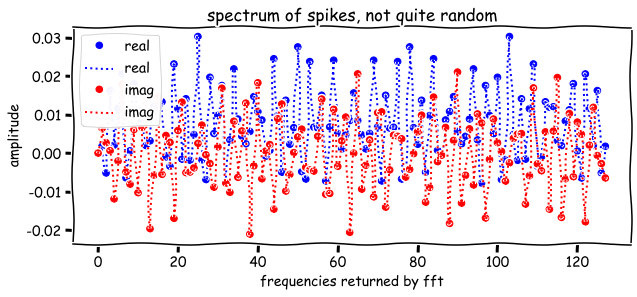

In [7]:
# Plot the real (blue) and imaginary (red) parts
figsize(10,4)

plot(specr,'bo', label='real')
plot(specr,'b:', label='real') # lines connecting DISCRETE points 
plot(speci,'ro', label='imag')
plot(speci,'r:', label='imag') # lines are meaningless; for clarity
title('spectrum of '+compose)
xlabel('frequencies returned by fft'); ylabel('amplitude')
legend(loc='best');

### Plot amplitude or *power* (amplitude squared) and phase
Should be symmetric since the input is real. 
But the mean of the data is in wavenumber 0, in the real (cosine) part.

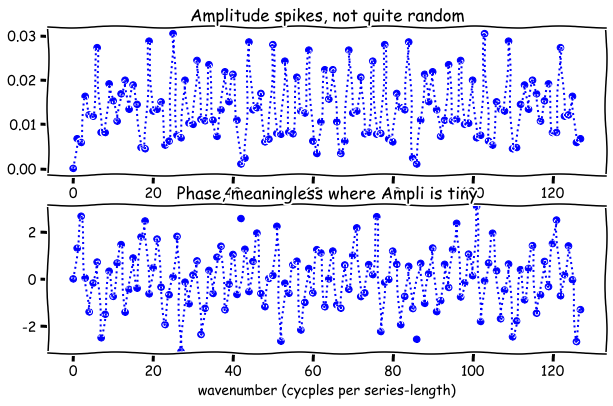

In [8]:
# Plot the amplitude and phase

figsize(10,6)
subplot(211)
plot(ampli,'bo'); 
plot(ampli,'b:'); 
title('Amplitude '+compose)

subplot(212)
plot(phase,'bo')
plot(phase*(ampli > 1e-3),'b:')
title('Phase, meaningless where Ampli is tiny')
xlabel('wavenumber (cycples per series-length)');
ylim([-pi,pi]);

### Tidy up the symmetry and labels for a nicer Power spectrum plot

In [23]:
# TAKE JUST THE LEFT HALF OF THE SYMMETRIC SPECTRUM
Wavenumbers = arange(N/2)

# BUT DOUBLE THE VALUEs, other than wavenumber 0
Amp2 = ampli[0:int(N/2)] *2.
Amp2[0] = 0

# Now power spectrum density is 1/2 amplitude squared since var(sin(x))=var(cos(x)) = 1/2
Power = (Amp2**2) /2.

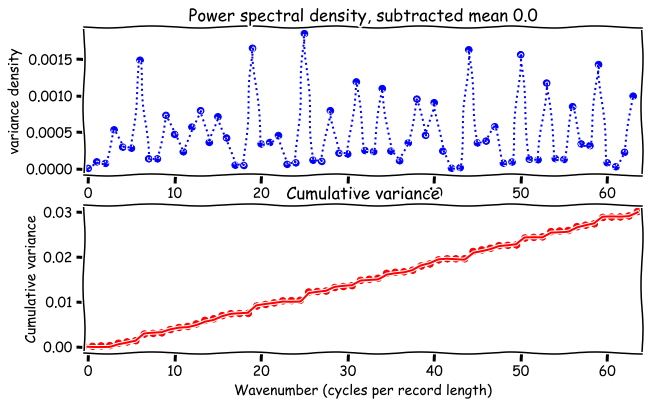

In [10]:
# Power spectral density plot
figsize(10,6)

subplot(211)
plot(Wavenumbers,Power ,'bo')
plot(Wavenumbers,Power ,'b:')
xlim([-0.5,N/2])

title('Power spectral density, subtracted mean '+str(ampli[0]))
ylabel('variance density');

# Cumulative power graph: offset x axis by half a wavenumber
CumWavenum  = concatenate(([-0.5],arange(N/2)+0.5))
CumVar      = concatenate(([0],   cumsum(Power) ))
                     
subplot(212)
plot(CumWavenum,CumVar,'ro')
plot(CumWavenum,CumVar,'r')
xlim([-0.5,N/2])

title('Cumulative variance')
xlabel('Wavenumber (cycles per record length)')
ylabel('Cumulative variance');

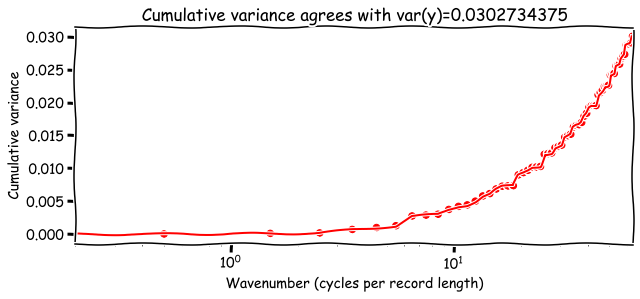

In [11]:
figsize(10,4)

semilogx(CumWavenum,CumVar,'ro')
semilogx(CumWavenum,CumVar,'r')
xlim([0.2 ,N/2])
title('Cumulative variance agrees with var(y)='+ str(var(y)))
xlabel('Wavenumber (cycles per record length)')
ylabel('Cumulative variance');

## Reconstruct (synthesize) data by meddling with phase. 
#### Notice that 1j is *i* in Python 

In [14]:
# BUT DOUBLE THE VALUEs, other than wavenumber 0
# Phase=0 gives the autocorrelation function
syn_phase = Amp2*0; explabel = 'phase=0, cosines pile up at 0 & 2pi'

# Phase = rand() makes synthetic data
# syn_phase = 2*pi*rand( len(syn_phase) ); explabel = 'random phases'

In [18]:
# Build the synthetic spectrum from real and imaginary parts
syn_spec =(    ampli*cos(phase)   #real part
         + 1j* ampli*sin(phase) ) #imag part

# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# And there is a near-zero imaginary part; strip it off with real()
syn_data = real( ifft(syn_spec)*N )

### Display the synthetic data (autocorrelation if phase=0) on the raw data

Text(0.5, 1.0, 'spikes, not quite random')

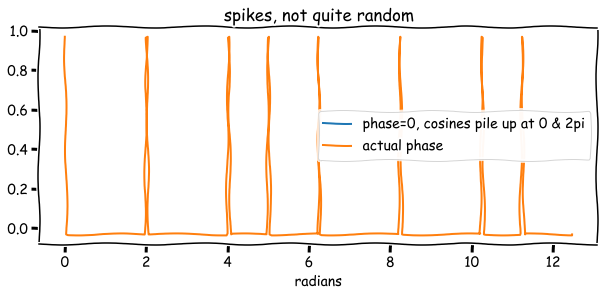

In [19]:
plot(xx,tile(syn_data,2), label=explabel)
plot(xx,yy, label='actual phase')
legend(loc='best')
xlabel('radians')
title(compose)

In [24]:
Amp2

array([0.        , 0.01338972, 0.01166991, 0.0325075 , 0.0241353 ,
       0.02352269, 0.05445386, 0.01621385, 0.01616148, 0.03812542,
       0.03049096, 0.02131632, 0.03363256, 0.03977531, 0.02667506,
       0.03761596, 0.02887124, 0.00939111, 0.00885101, 0.05738259,
       0.02586346, 0.02665688, 0.03001872, 0.01050553, 0.01231808,
       0.06077259, 0.0149448 , 0.01379576, 0.03977531, 0.02039525,
       0.01985754, 0.04868579, 0.02209709, 0.02148048, 0.04677167,
       0.02174862, 0.01445779, 0.02641929, 0.04357679, 0.03008173,
       0.04244278, 0.02178781, 0.00198982, 0.00466755, 0.05701474,
       0.02642034, 0.02735236, 0.03380479, 0.01195886, 0.01323762,
       0.05581781, 0.01577893, 0.01538081, 0.04835756, 0.01634064,
       0.01560971, 0.04113309, 0.0258671 , 0.02496388, 0.05334479,
       0.01231123, 0.00670428, 0.02099343, 0.04450108])

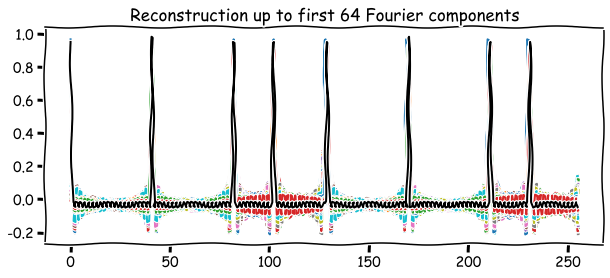

In [85]:
N = 64

recon = xx.copy() *0 # right size, empty
plot(yy) 
title('Reconstruction up to first '+str(N)+' Fourier components')

# Loop over wavenumbers, reconstructing
for i in range(N): #range(len(Amp2)):
    recon = recon + Amp2[i]*cos(xx*i + phase[i])
    plot(recon, label = str(i))
    
plot(recon,'k')
#legend(loc='best')
#reconfull = recon
#plot(reconfull,'k')
#plot(yy)

In [34]:
for i in range(0): #range(len(Amp2)):
    # print(i); print("Amp2 is ", Amp2[i]) 
    subplots(nrows=10, sharex=True, )
    recon = recon + Amp2[i]*cos(xx*i + phase[i])
    plot(recon)
    

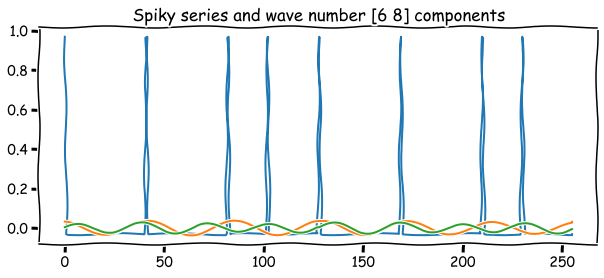

In [71]:
N = np.array([3,4])

recon = xx.copy() *0 # right size, empty
plot(yy) 
title('Spiky series and wave number '+str(N*2)+' components')

for i in N: 
    plot(Amp2[i]*cos(xx*i + phase[i]))

In [85]:
len(phase)

128

# Make realizations of a Gaussian power spectrum 

Text(0.5,1,'Gaussian power spectrum')

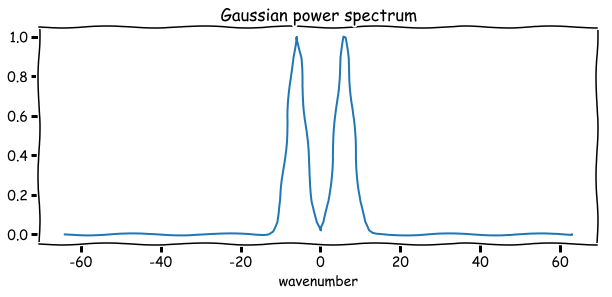

In [189]:
# Gaussian power spectrum with peak and width 
WN = arange(N)-N/2 
PeakWavenumber = 6
GaussWidth = 3

GaussPower = ampli*0 + exp(-( (abs(WN) - PeakWavenumber)/GaussWidth)**2 )

plot((WN), GaussPower)
xlabel('wavenumber')
title('Gaussian power spectrum')

#sqrt(sum(Power))

# Manual reconstruction
## cosine with phase offset
### random for a realization, phase=0 for autocorrelation type structure
"fft of a Gaussian is a Gaussian" but how does that apply? the reconstruction is always wavelike, not hump-like

In [190]:
# BUT DOUBLE THE VALUEs, other than wavenumber 0
Amp2 = sqrt(GaussPower)[int(N/2):] *2.
Amp2[0] = 0

In [191]:
# Phase=0 gives the autocorrelation function
syn_phase = Amp2*0; explabel = 'phase=0, cosines pile up at 0 & 2pi'

# Phase = rand() makes synthetic data
# syn_phase = 2*pi*rand( len(syn_phase) ); explabel = 'random phases'

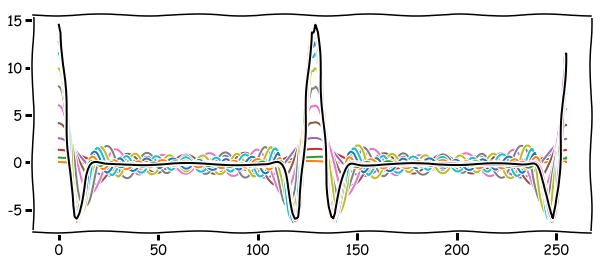

In [192]:
recon = xx.copy() *0 # right size, empty
plot(recon) 

# Loop over wavenumbers, reconstructing
for i in range(17): #range(len(Amp2)):
    # print(i); print("Amp2 is ", Amp2[i]) 
    recon = recon + Amp2[i]*cos(xx*i + syn_phase[i])
    plot(recon)
    
plot(recon,'k')

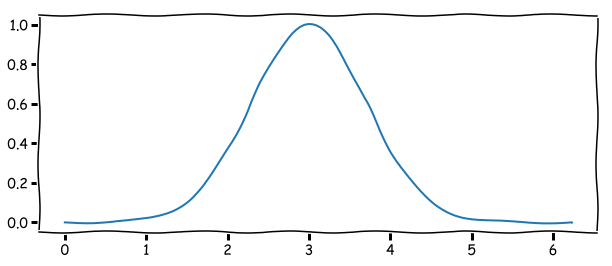

In [198]:
# Probability and spike creation

Prob = exp(- (x-3)**2 )
plot(x, Prob)

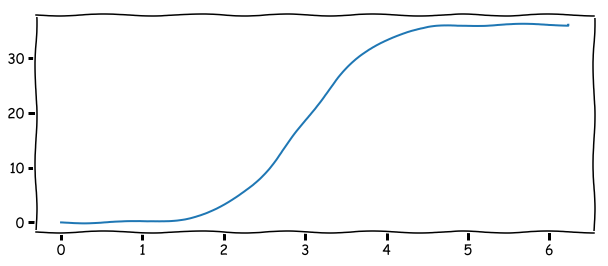

In [210]:
a = cumsum(Prob)
plot(x, a)

In [230]:
# Create a spike at a random location (here is the index) based on Prob
idx = (abs( rand(1)*sum(Prob)-a) ).argmin()
idx

61

# Make a model of the convection event field with conditional probabilities 

In [406]:
# A function to put in some events 
def dispatch(empty, Prob, N):
    conv_now = empty.copy()
    cumprob = cumsum(Prob)
    for i in arange(N):
        idx = (abs( rand(1)*sum(Prob) -cumprob) ).argmin()
        conv_now[idx] = 1
    return(conv_now)

In [410]:
def smooth_boxcar(array1d, kernel_size): 
    kernel = np.ones(kernel_size) / kernel_size
    return(np.convolve(array1d, kernel, mode='same'))

In [411]:
def smooth_cyc( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

# Initialize with uniform probability

In [521]:
x = arange(500)
Prob = x.copy()*0 +1 # uniform initially
empty = x.copy()*0
ker = empty.copy(); ker[0:10] = 0.1 # Kernel function for a cyclic smoother

# Initialize the stack with one time step
conv = x.copy()*0

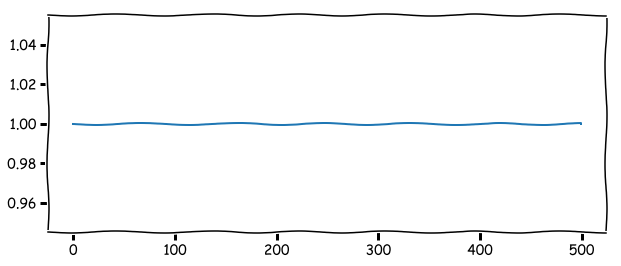

In [522]:
plot(Prob)

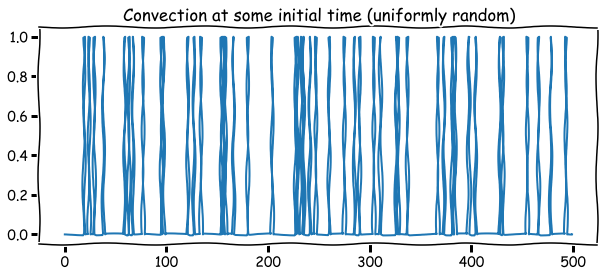

In [523]:
conv_now = dispatch(empty, Prob, 50)
plot(conv_now); title('Convection at some initial time (uniformly random)');

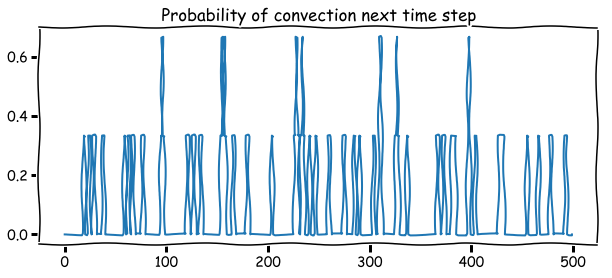

In [524]:
Prob = smooth_boxcar(conv_now,3)
plot(Prob); title('Probability of convection next time step');

# Probability model: just smoothed neighbors for now 

Text(0.5,1,'Convection probability = boxcar smoother (width 11)')

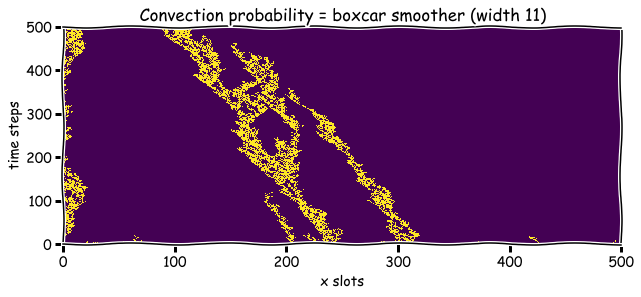

In [525]:
# Run for N time steps 
for i in arange(499):
    # Prob = smooth_cyc(conv_now,ker) # seems to have a bias 
    Prob = smooth_boxcar(conv_now,3) 
    conv_now = dispatch(empty, Prob, 50)
    conv = np.vstack([conv,conv_now])

pcolor(conv)
xlabel('x slots'); ylabel('time steps')
title('Convection probability = boxcar smoother (width 11)')

Text(0.5,1,'Convection probability = boxcar smoother (width 3)')

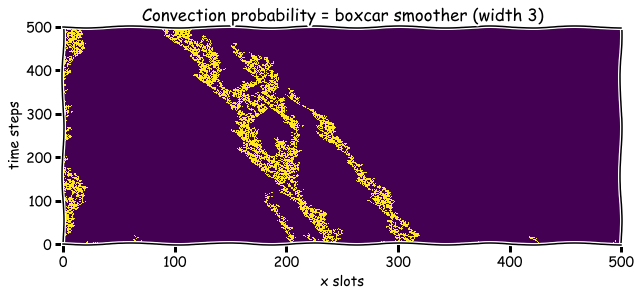

In [526]:
pcolor(conv)
xlabel('x slots'); ylabel('time steps')
title('Convection probability = boxcar smoother (width 3)')

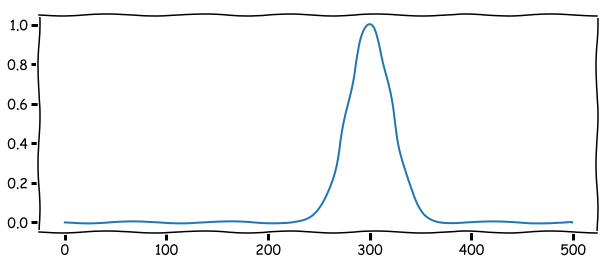

In [368]:
Prob = exp(- ((x-300)/30)**2 )

plot(Prob)

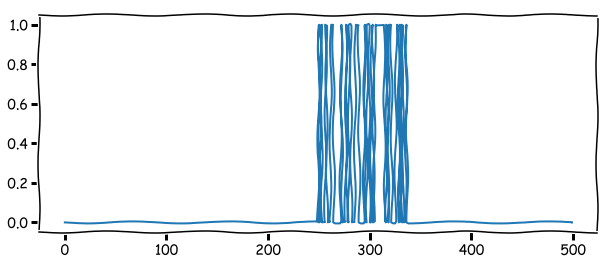

In [369]:
plot(dispatch(empty, Prob, 50))

In [370]:
empty

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,